In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()


class ChildState(TypedDict):
    messages: Annotated[list, add_messages]


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)


def agent(state: ChildState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def tools_router(state: ChildState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END


tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)


subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges(
    "agent", tools_router, {"tool_node": "tool_node", END: END}
)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

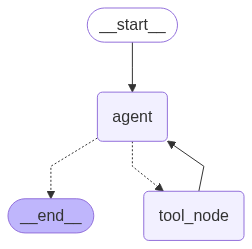

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(search_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))
)

In [7]:
search_app.invoke({"messages": "How is the weather now in Avon, CT"})

{'messages': [HumanMessage(content='How is the weather now in Avon, CT', additional_kwargs={}, response_metadata={}, id='606fd6cc-7655-40c5-9b63-4fe1878b2da0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_498k', 'function': {'arguments': '{"query": "Avon CT weather now"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 288, 'total_tokens': 310, 'completion_time': 0.029333333, 'prompt_time': 0.014108659, 'queue_time': 0.505306379, 'total_time': 0.043441992}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4e1bf5ec-4f16-4564-a28e-45fdedff8845-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Avon CT weather now'}, 'id': 'call_498k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 22, 'total_tokens': 310}),
  ToolMessage(content='[{"

**_ Shared Schema _**


In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage


class ParentState(TypedDict):
    messages: Annotated[list, add_messages]


parent_graph = StateGraph(ParentState)

parent_graph.add_node("search_agent", search_app)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

result = parent_app.invoke({"messages": "What is the weather in Santiago, Chile"})
result

{'messages': [HumanMessage(content='What is the weather in Santiago, Chile', additional_kwargs={}, response_metadata={}, id='15cd53a3-cc30-4000-bcb4-b3265ab103c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8w70', 'function': {'arguments': '{"query": "Santiago Chile weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.028, 'prompt_time': 0.018077085, 'queue_time': 0.308748008, 'total_time': 0.046077085}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0d611194-136d-4a64-be8c-b3cc39414156-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Santiago Chile weather'}, 'id': 'call_8w70', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307}),
  ToolMessage(content=

**\* Different Schema \*\***


In [11]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage


class QueryState(TypedDict):
    query: str
    response: str


def search_agent(state: QueryState) -> Dict:
    subgraph_input = {"messages": [HumanMessage(content=state["query"])]}

    subgraph_result = search_app.invoke(subgraph_input)
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

parent_graph = StateGraph(QueryState)

parent_graph.add_node("search_agent", search_agent)
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

result = parent_app.invoke({"query": "how is the weather in Santiago, Chile?"})
print(result)

{'query': 'how is the weather in Santiago, Chile?', 'response': 'Based on the search results, the weather in Santiago, Chile is currently foggy with a temperature of 8.1°C (46.6°F). However, the detailed forecast for May 2025 indicates that it will be sunny with a high temperature of 21°C (70°F) and a low temperature of 8°C (46°F) on May 14th.'}
